In [51]:
import pandas as pd
import re
import numpy as np
import string
import nltk
import unidecode
import seaborn as sns
from wordcloud import WordCloud
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
import matplotlib.pyplot as pyplot
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import textstat
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn import preprocessing
from collections import Counter
from bs4 import BeautifulSoup
import warnings
warnings.filterwarnings('ignore')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
df = pd.read_csv("datasets/disaster_tweets_train.csv",na_values=['',' ','nan'])
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
df['keyword'].value_counts()

fatalities               45
deluge                   42
armageddon               42
sinking                  41
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

In [4]:
#only slightly imbalanced dataset, nothing major
(df['target'].value_counts()/len(df))*100 

0    57.034021
1    42.965979
Name: target, dtype: float64

In [5]:
#Explore the number of unique values for each feature
for col in df.columns:
    print(f'{col}: {df[col].nunique()} unique values')

id: 7613 unique values
keyword: 221 unique values
location: 3341 unique values
text: 7503 unique values
target: 2 unique values


In [6]:
#Checking columns with missing values
missing_prop=df.isna().sum()/len(df)
missing_prop[missing_prop>0].sort_values(ascending=False)

location    0.332720
keyword     0.008013
dtype: float64

In [7]:
#replacing string with another string
df['keyword']=df['keyword'].replace(regex=[r'%20'], value='_')

In [8]:
# fixing categoricals
imputer_cat = SimpleImputer(missing_values = np.nan, strategy='constant')
imputer_cat.fit(df.select_dtypes(exclude=['int64','float64']))
df[df.select_dtypes(exclude=['int64','float64']).columns] = imputer_cat.transform(df.select_dtypes(exclude=['int64','float64']))

SimpleImputer(strategy='constant')

In [9]:
#data preprocessing 
wn=nltk.WordNetLemmatizer()
stop_words=set(stopwords.words('english')+stopwords.words('spanish')+['u','im','dont','cuz','lol','ur','ure','doing'])

def clean_text(text):
        text = BeautifulSoup(text, ["lxml"]).get_text()        
        text="".join([char.lower() for char in text if char not in string.punctuation])
        text= re.sub(r'\d+', '', text)
        text=re.sub(r'http\S+|www\S+', '', text).strip()
        tokens=nltk.word_tokenize(text.strip())
        text=[t for t in tokens if t not in stop_words]
        text=[unidecode.unidecode(w) for w in text]
        text=" ".join([wn.lemmatize(word)for word in text])
        return text

df["text_clean"]=df["text"].apply(lambda x:clean_text(x))

In [10]:
df.head()

,id,keyword,location,text,target,text_clean
0,1,missing_value,missing_value,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake may allah forgive u
1,4,missing_value,missing_value,Forest fire near La Ronge Sask. Canada,1,forest fire near ronge sask canada
2,5,missing_value,missing_value,All residents asked to 'shelter in place' are ...,1,resident asked shelter place notified officer ...
3,6,missing_value,missing_value,"13,000 people receive #wildfires evacuation or...",1,people receive wildfire evacuation order calif...
4,7,missing_value,missing_value,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby alaska smoke wildfire pour...


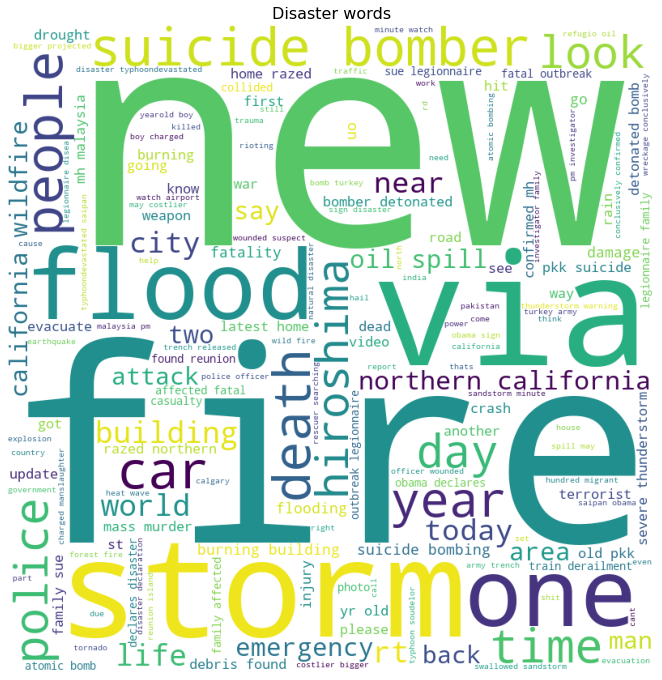

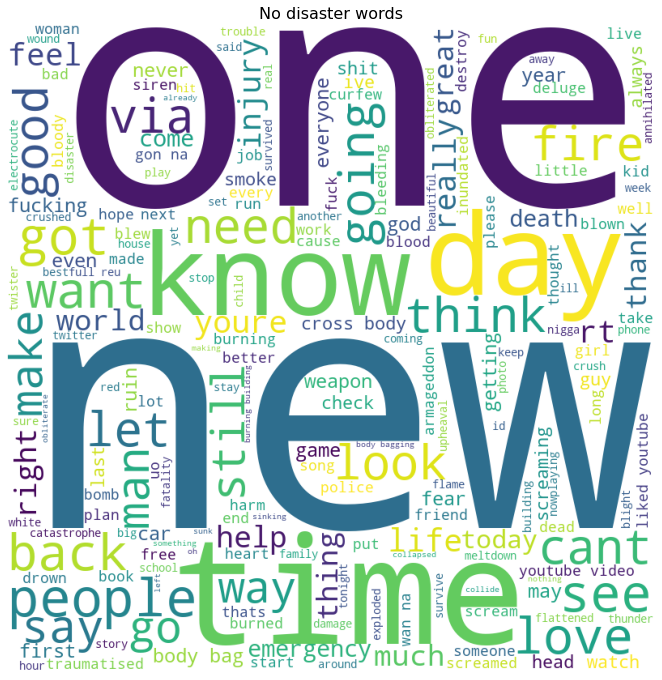

In [11]:
#Checking most popular words in text for non disaster and disaster
no_disaster=pd.DataFrame(df[df['target']==0]['text_clean'])
all_words_no_disaster= ' '.join(no_disaster['text_clean'])

#Checking most popular words in sentences with Polarity 1
all_words_disaster=pd.DataFrame(df[df['target']==1]['text_clean'])
all_words_disaster = ' '.join(all_words_disaster['text_clean'])

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(all_words_disaster)
 
# plot the WordCloud image                       
_=pyplot.figure(figsize = (9, 9), facecolor = None)
_=pyplot.imshow(wordcloud)
_=pyplot.axis("off")
_=pyplot.tight_layout(pad = 0)
_=pyplot.title('Disaster words',size=16)

pyplot.show()

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(all_words_no_disaster)
 
# plot the WordCloud image                       
_=pyplot.figure(figsize = (9, 9), facecolor = None)
_=pyplot.imshow(wordcloud)
_=pyplot.axis("off")
_=pyplot.tight_layout(pad = 0)
_=pyplot.title('No disaster words',size=16) 
pyplot.show()

<AxesSubplot:ylabel='target'>

Text(0.5, 1.0, 'Disaster vs Not disaster tweets')

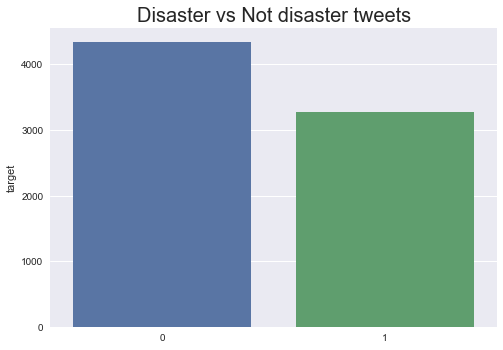

In [12]:
#Checking distribution between 0 and 1 values in target feature
pyplot.style.use('seaborn')
sns.barplot(df['target'].value_counts().index,df['target'].value_counts())
pyplot.title('Disaster vs Not disaster tweets',size=20)

<AxesSubplot:xlabel='keyword'>

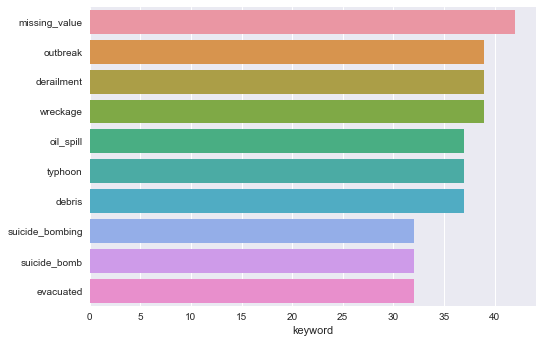

In [13]:
#Most frequent keywords for Disaster tweets
sns.barplot(y=df[df['target']==1]['keyword'].value_counts()[:10].index,
            x=df[df['target']==1]['keyword'].value_counts()[:10],
            orient='h')

<AxesSubplot:xlabel='keyword'>

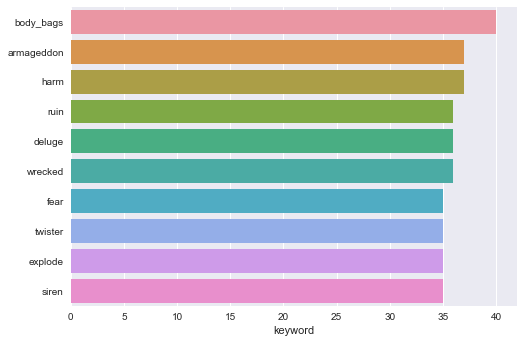

In [14]:
#Most frequent keywords for Non disaster tweets
sns.barplot(y=df[df['target']==0]['keyword'].value_counts()[:10].index,
            x=df[df['target']==0]['keyword'].value_counts()[:10],
            orient='h')

<AxesSubplot:xlabel='location'>

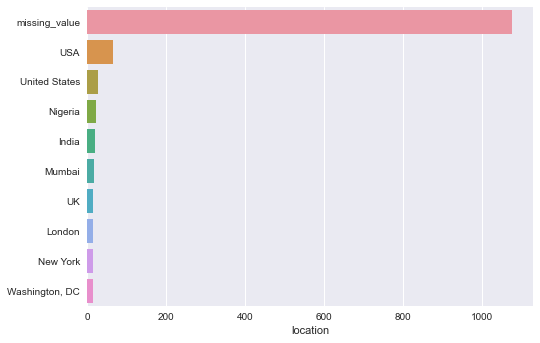

In [15]:
#Most frequent keywords for Disaster tweets locations
sns.barplot(y=df[df['target']==1]['location'].value_counts()[:10].index,
            x=df[df['target']==1]['location'].value_counts()[:10],
            orient='h')

In [17]:
vectorizer = TfidfVectorizer(max_df=0.8, min_df=10,
                            max_features=1000, #only keep 1000 most frequent words
                            ngram_range=[1,3]) 

dtm = vectorizer.fit_transform(df['text_clean'])

In [20]:
model_results=list()
for n_comp in np.arange(1,30,1):
    lda_model = LatentDirichletAllocation(n_components=n_comp,
                                      doc_topic_prior=None,
                                      topic_word_prior=None,
                                      max_iter=200, 
                                      learning_method='batch', 
                                      random_state=42,
                                      n_jobs=2,
                                      verbose=0)  
    lda_output = lda_model.fit(dtm)

    # Log Likelyhood: Higher the better
    ll = lda_model.score(dtm)

    # Perplexity: Lower the better
    perp = lda_model.perplexity(dtm)
    
    df_results = pd.DataFrame({"number_topics"   : [n_comp],
                              "Log likelyhood"   : [ll],
                              "Perplexity"       : [perp]
                      })
    model_results.append(df_results)
    
print(model_results)

[   number_topics  Log likelyhood  Perplexity
0              1  -108515.512935  911.168444,    number_topics  Log likelyhood  Perplexity
0              2  -111233.800123  1080.77651,    number_topics  Log likelyhood   Perplexity
0              3  -113691.088362  1261.115218,    number_topics  Log likelyhood   Perplexity
0              4  -115646.447814  1425.884268,    number_topics  Log likelyhood   Perplexity
0              5  -117142.151221  1566.308683,    number_topics  Log likelyhood   Perplexity
0              6  -117991.463745  1652.118092,    number_topics  Log likelyhood  Perplexity
0              7  -119325.204284  1796.45718,    number_topics  Log likelyhood   Perplexity
0              8  -120589.496287  1944.905693,    number_topics  Log likelyhood   Perplexity
0              9  -121268.225274  2029.597259,    number_topics  Log likelyhood   Perplexity
0             10  -122150.630083  2145.241264,    number_topics  Log likelyhood   Perplexity
0             11  -122818.520

In [21]:
#chose 10 for n_components
lda_model = LatentDirichletAllocation(n_components=10,
                                      doc_topic_prior=None,
                                      topic_word_prior=None,
                                      max_iter=200, 
                                      learning_method='batch', 
                                      random_state=42,
                                      n_jobs=2,
                                      verbose=0)
lda_output = lda_model.fit(dtm)

# Log Likelyhood: Higher the better
ll = lda_model.score(dtm)

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
perp = lda_model.perplexity(dtm)

In [22]:
f'l1 score is {ll}'
f'perplexity score is {perp}'

'l1 score is -122150.63008344463'

'perplexity score is 2145.2412640289413'

In [23]:
#top words per topic

for i,topic in enumerate(lda_model.components_):
    print("\n")
    print(f"The top 10 words for topic # {i}\n")
    for index in topic.argsort()[-10:]:
        print(vectorizer.get_feature_names()[index])



The top 10 words for topic # 0

pandemonium
loud
demolished
murder
battle
photo
hazard
youtube
video
fatality


The top 10 words for topic # 1

heat
ambulance
body bag
casualty
inundated
read
wildfire
war
body
bag


The top 10 words for topic # 2

annihilated
collided
detonate
flood
two
blood
collapse
injury
disaster
weapon


The top 10 words for topic # 3

evacuation
time
destruction
thunder
earthquake
hiroshima
bombing
bomb
suicide
emergency


The top 10 words for topic # 4

best
back
smoke
screaming
day
get
one
hostage
look
like


The top 10 words for topic # 5

oil
rescued
story
riot
flame
burning building
truck
burning
building
fire


The top 10 words for topic # 6

flattened
like
live
burned
youre
wreck
feel
let
siren
death


The top 10 words for topic # 7

crush
thunderstorm
drowning
scream
natural
plan
man
via
accident
storm


The top 10 words for topic # 8

demolish
crashed
terrorist
trauma
love
attack
th
police
wound
curfew


The top 10 words for topic # 9

displaced
blown


## Topic modelling with gensim

In [24]:
import gensim
from gensim import corpora

In [25]:
doc_clean=[clean_text(doc).split() for doc in df['text']]

In [26]:
dictionary=corpora.Dictionary(doc_clean)
doc_term_matrix=[dictionary.doc2bow(doc) for doc in doc_clean]

In [27]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=doc_term_matrix,
                                           id2word=dictionary,
                                           num_topics=8, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

In [28]:
print(lda_model.print_topics(num_topics=8))

[(0, '0.046*"weapon" + 0.024*"wild" + 0.024*"killed" + 0.023*"one" + 0.020*"train" + 0.019*"volcano" + 0.017*"dead" + 0.016*"get" + 0.014*"earthquake" + 0.013*"abc"'), (1, '0.071*"mh" + 0.070*"wreckage" + 0.066*"pm" + 0.051*"family" + 0.048*"conclusively" + 0.041*"malaysia" + 0.020*"via" + 0.018*"warning" + 0.014*"island" + 0.012*"help"'), (2, '0.068*"fire" + 0.043*"news" + 0.021*"storm" + 0.020*"texas" + 0.015*"violent" + 0.014*"see" + 0.013*"missing" + 0.013*"breaking" + 0.012*"good" + 0.012*"wrecked"'), (3, '0.054*"wildfire" + 0.051*"california" + 0.041*"suspect" + 0.018*"part" + 0.018*"people" + 0.014*"tornado" + 0.012*"need" + 0.012*"bomber" + 0.012*"lot" + 0.011*"life"'), (4, '0.104*"wreck" + 0.044*"like" + 0.029*"home" + 0.022*"shot" + 0.019*"war" + 0.018*"new" + 0.014*"love" + 0.014*"windstorm" + 0.014*"seek" + 0.013*"four"'), (5, '0.060*"confirmed" + 0.054*"wound" + 0.042*"police" + 0.039*"investigator" + 0.033*"officer" + 0.030*"car" + 0.015*"say" + 0.013*"exchanging" + 0.012

In [29]:
lda_model.log_perplexity(doc_term_matrix)

-12.149953778432073

In [30]:
from gensim.models import CoherenceModel

coherence_model_lda=CoherenceModel(model=lda_model,texts=doc_clean,dictionary=dictionary,coherence='c_v')

coherence_lda=coherence_model_lda.get_coherence()

print('\nCoherence Score: ',coherence_lda)


Coherence Score:  0.5569301297836065


<AxesSubplot:>

Text(0.5, 1.0, 'Topic 0')

(-0.5, 2499.5, 1799.5, -0.5)

<AxesSubplot:>

Text(0.5, 1.0, 'Topic 1')

(-0.5, 2499.5, 1799.5, -0.5)

<AxesSubplot:>

Text(0.5, 1.0, 'Topic 2')

(-0.5, 2499.5, 1799.5, -0.5)

<AxesSubplot:>

Text(0.5, 1.0, 'Topic 3')

(-0.5, 2499.5, 1799.5, -0.5)

<AxesSubplot:>

Text(0.5, 1.0, 'Topic 4')

(-0.5, 2499.5, 1799.5, -0.5)

<AxesSubplot:>

Text(0.5, 1.0, 'Topic 5')

(-0.5, 2499.5, 1799.5, -0.5)

<AxesSubplot:>

Text(0.5, 1.0, 'Topic 6')

(-0.5, 2499.5, 1799.5, -0.5)

<AxesSubplot:>

Text(0.5, 1.0, 'Topic 7')

(-0.5, 2499.5, 1799.5, -0.5)

(-0.5, 2499.5, 1799.5, -0.5)

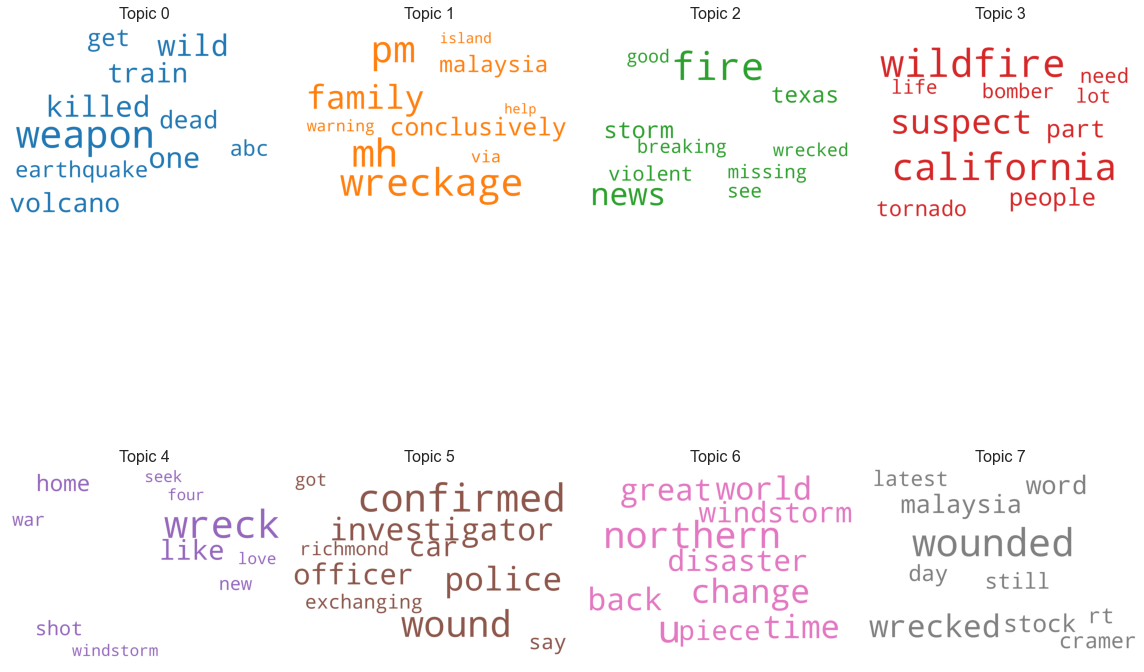

In [31]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 4, figsize=(16,16), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=350)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

<BarContainer object of 10 artists>

<BarContainer object of 10 artists>

Text(0, 0.5, 'Word Count')

(0.0, 0.03)

(0.0, 4500.0)

Text(0.5, 1.0, 'Topic: 0')

[Text(0, 0, 'weapon'),
 Text(1, 0, 'wild'),
 Text(2, 0, 'killed'),
 Text(3, 0, 'one'),
 Text(4, 0, 'train'),
 Text(5, 0, 'volcano'),
 Text(6, 0, 'dead'),
 Text(7, 0, 'get'),
 Text(8, 0, 'earthquake'),
 Text(9, 0, 'abc')]

No handles with labels found to put in legend.


<BarContainer object of 10 artists>

<BarContainer object of 10 artists>

Text(0, 0.5, 'Word Count')

(0.0, 0.03)

(0.0, 4500.0)

Text(0.5, 1.0, 'Topic: 1')

[Text(0, 0, 'mh'),
 Text(1, 0, 'wreckage'),
 Text(2, 0, 'pm'),
 Text(3, 0, 'family'),
 Text(4, 0, 'conclusively'),
 Text(5, 0, 'malaysia'),
 Text(6, 0, 'via'),
 Text(7, 0, 'warning'),
 Text(8, 0, 'island'),
 Text(9, 0, 'help')]

No handles with labels found to put in legend.


<BarContainer object of 10 artists>

<BarContainer object of 10 artists>

Text(0, 0.5, 'Word Count')

(0.0, 0.03)

(0.0, 4500.0)

Text(0.5, 1.0, 'Topic: 2')

[Text(0, 0, 'fire'),
 Text(1, 0, 'news'),
 Text(2, 0, 'storm'),
 Text(3, 0, 'texas'),
 Text(4, 0, 'violent'),
 Text(5, 0, 'see'),
 Text(6, 0, 'missing'),
 Text(7, 0, 'breaking'),
 Text(8, 0, 'good'),
 Text(9, 0, 'wrecked')]

No handles with labels found to put in legend.


<BarContainer object of 10 artists>

<BarContainer object of 10 artists>

Text(0, 0.5, 'Word Count')

(0.0, 0.03)

(0.0, 4500.0)

Text(0.5, 1.0, 'Topic: 3')

[Text(0, 0, 'wildfire'),
 Text(1, 0, 'california'),
 Text(2, 0, 'suspect'),
 Text(3, 0, 'part'),
 Text(4, 0, 'people'),
 Text(5, 0, 'tornado'),
 Text(6, 0, 'need'),
 Text(7, 0, 'bomber'),
 Text(8, 0, 'lot'),
 Text(9, 0, 'life')]

No handles with labels found to put in legend.


<BarContainer object of 10 artists>

<BarContainer object of 10 artists>

Text(0, 0.5, 'Word Count')

(0.0, 0.03)

(0.0, 4500.0)

Text(0.5, 1.0, 'Topic: 4')

[Text(0, 0, 'wreck'),
 Text(1, 0, 'like'),
 Text(2, 0, 'home'),
 Text(3, 0, 'shot'),
 Text(4, 0, 'war'),
 Text(5, 0, 'new'),
 Text(6, 0, 'love'),
 Text(7, 0, 'windstorm'),
 Text(8, 0, 'seek'),
 Text(9, 0, 'four')]

No handles with labels found to put in legend.


<BarContainer object of 10 artists>

<BarContainer object of 10 artists>

Text(0, 0.5, 'Word Count')

(0.0, 0.03)

(0.0, 4500.0)

Text(0.5, 1.0, 'Topic: 5')

[Text(0, 0, 'confirmed'),
 Text(1, 0, 'wound'),
 Text(2, 0, 'police'),
 Text(3, 0, 'investigator'),
 Text(4, 0, 'officer'),
 Text(5, 0, 'car'),
 Text(6, 0, 'say'),
 Text(7, 0, 'exchanging'),
 Text(8, 0, 'richmond'),
 Text(9, 0, 'got')]

No handles with labels found to put in legend.


<BarContainer object of 10 artists>

<BarContainer object of 10 artists>

Text(0, 0.5, 'Word Count')

(0.0, 0.03)

(0.0, 4500.0)

Text(0.5, 1.0, 'Topic: 6')

[Text(0, 0, 'u'),
 Text(1, 0, 'northern'),
 Text(2, 0, 'change'),
 Text(3, 0, 'time'),
 Text(4, 0, 'world'),
 Text(5, 0, 'back'),
 Text(6, 0, 'great'),
 Text(7, 0, 'disaster'),
 Text(8, 0, 'windstorm'),
 Text(9, 0, 'piece')]

No handles with labels found to put in legend.


<BarContainer object of 10 artists>

<BarContainer object of 10 artists>

Text(0, 0.5, 'Word Count')

(0.0, 0.03)

(0.0, 4500.0)

Text(0.5, 1.0, 'Topic: 7')

[Text(0, 0, 'wounded'),
 Text(1, 0, 'wrecked'),
 Text(2, 0, 'word'),
 Text(3, 0, 'malaysia'),
 Text(4, 0, 'stock'),
 Text(5, 0, 'day'),
 Text(6, 0, 'still'),
 Text(7, 0, 'rt'),
 Text(8, 0, 'cramer'),
 Text(9, 0, 'latest')]

No handles with labels found to put in legend.


Text(0.5, 1.05, 'Word Count and Importance of Topic Keywords')

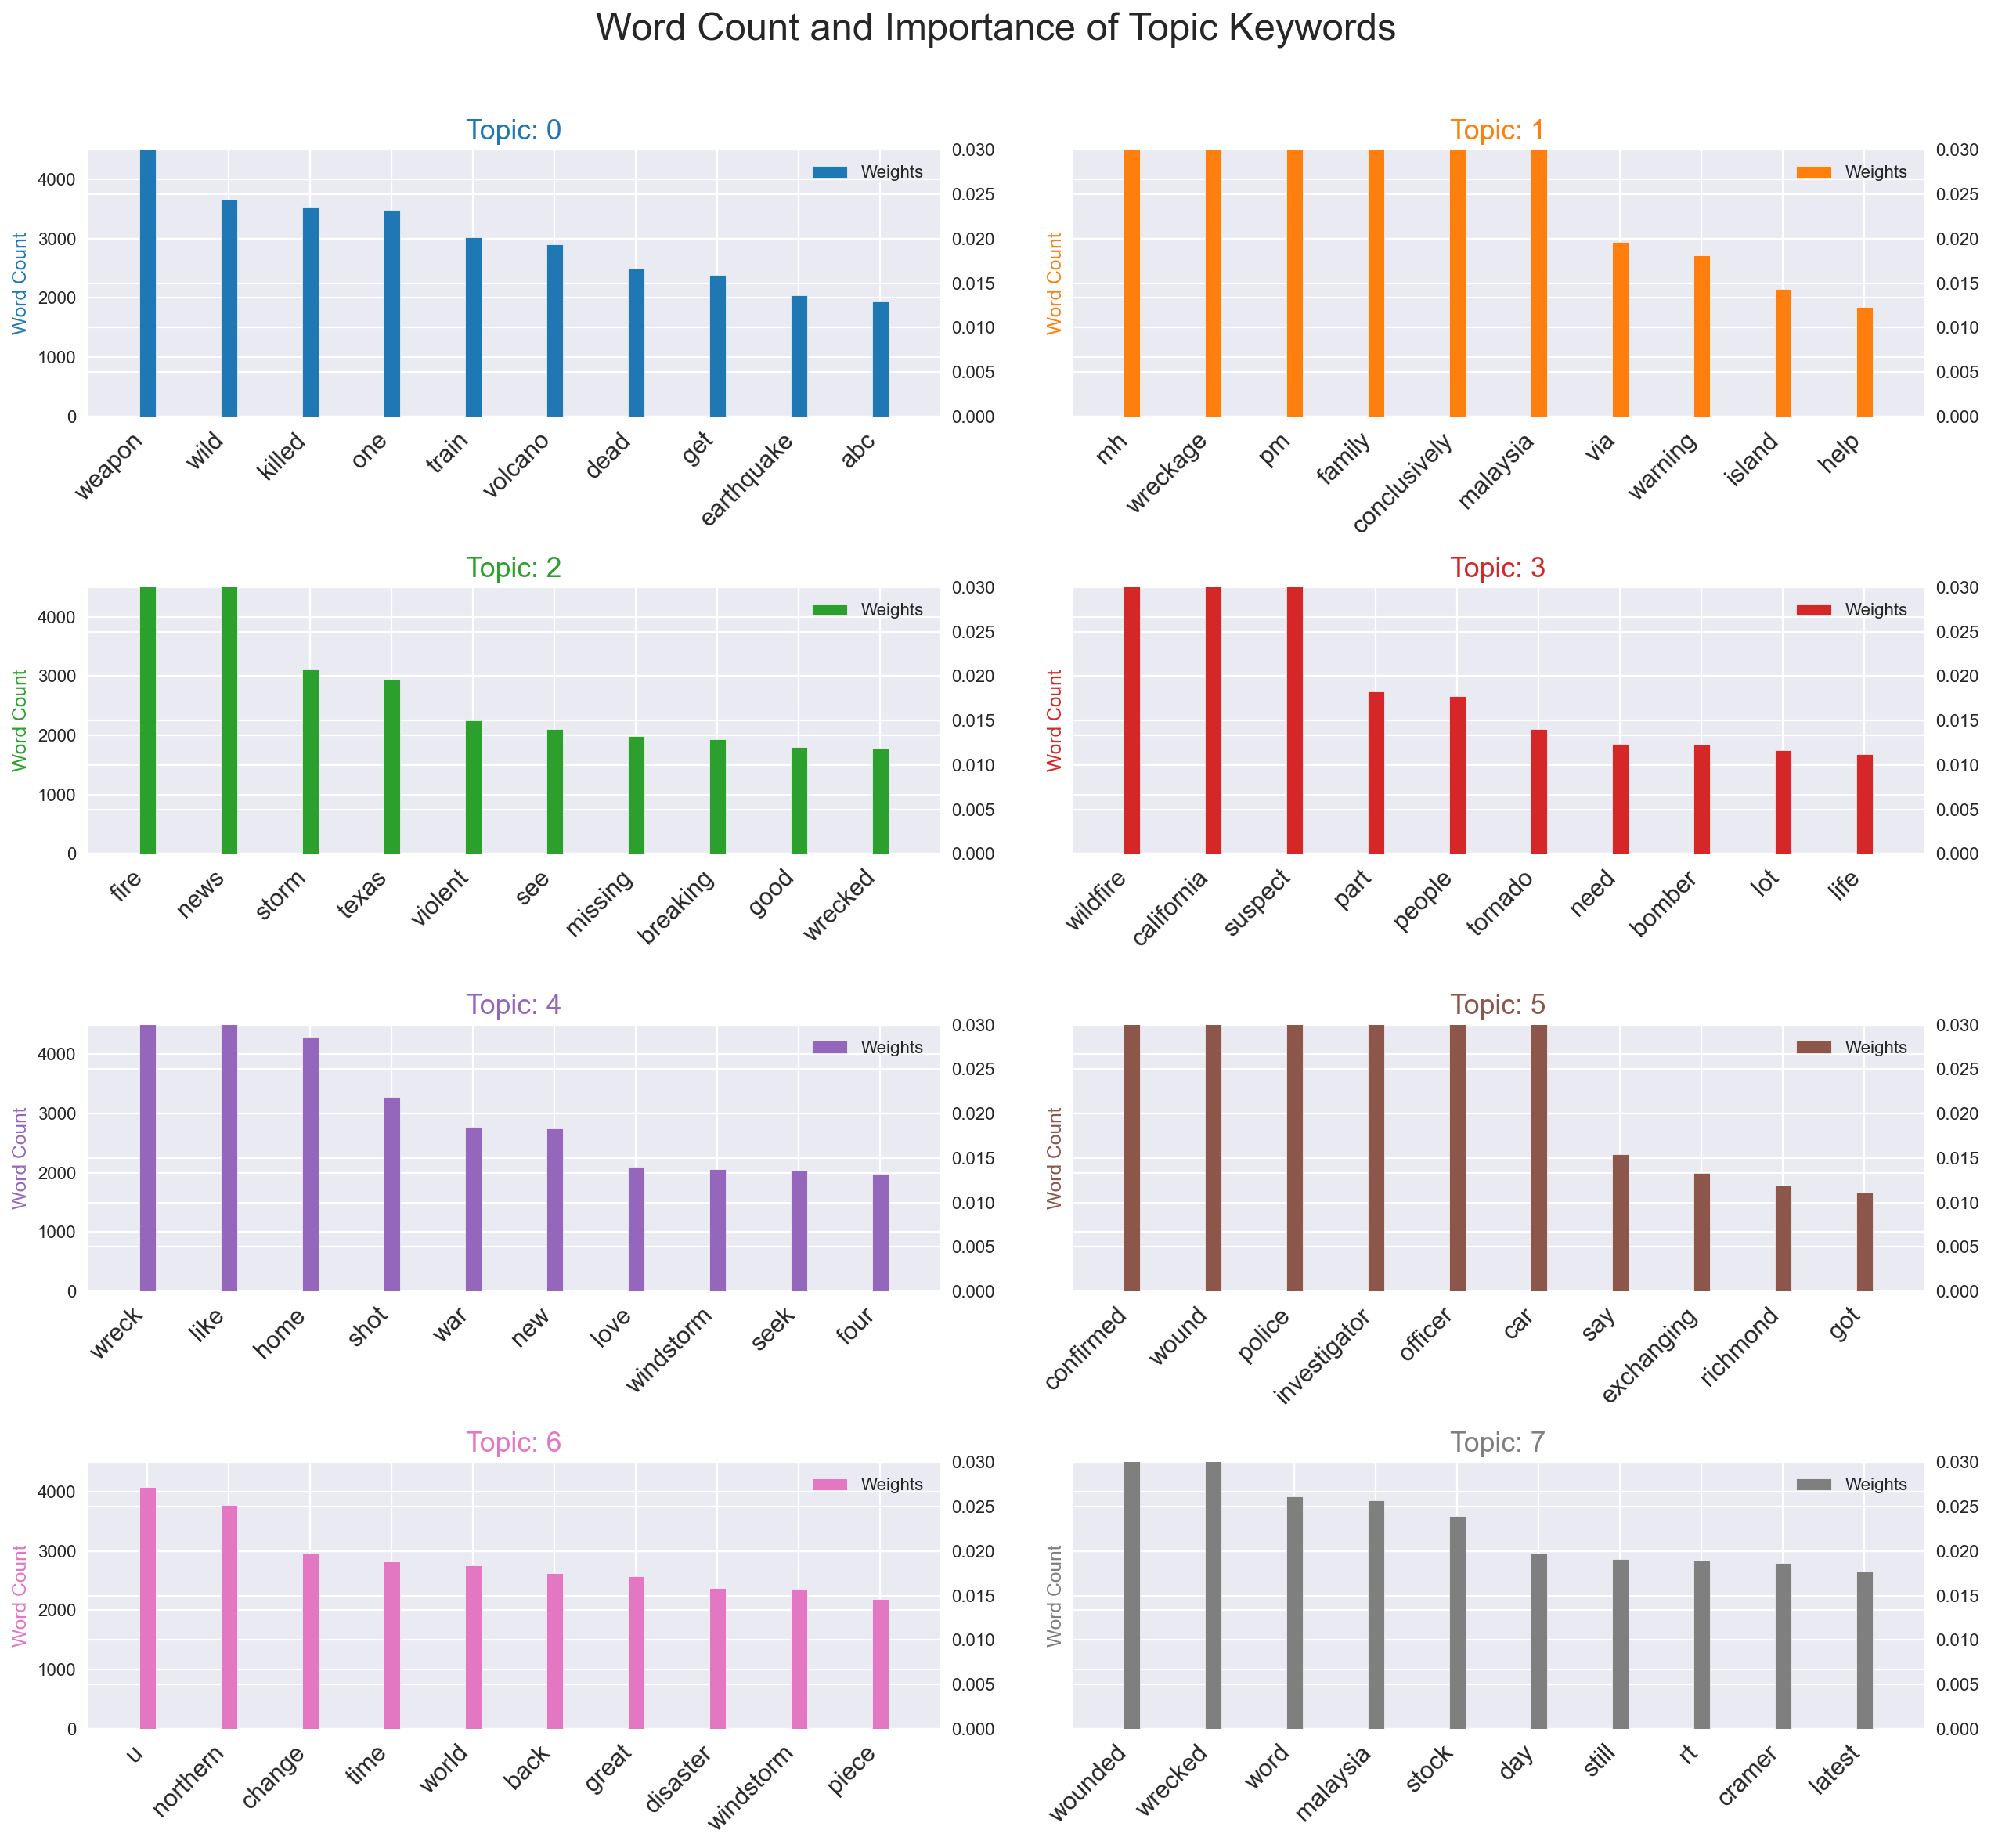

In [628]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in df['text_clean'] for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df_ = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(4, 2, figsize=(16,14), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df_.loc[df_.topic_id==i, :], color=cols[i], width=0.5, alpha=0)
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df_.loc[df_.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 4500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df_.loc[df_.topic_id==i, 'word'], rotation=45, horizontalalignment= 'right',size=14)
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

In [52]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary=dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.178064 -0.094105       1        1  17.534864
6      0.079136  0.070854       2        1  12.990207
4      0.127584 -0.014193       3        1  12.837823
2      0.038903  0.041308       4        1  12.578021
5     -0.161258  0.236159       5        1  12.138356
3      0.047726  0.028128       6        1  11.639914
1     -0.191589 -0.223221       7        1  10.419402
7     -0.118566 -0.044929       8        1   9.861411, topic_info=            Term        Freq       Total Category  logprob  loglift
736        wreck  916.000000  916.000000  Default  30.0000  30.0000
8           fire  585.000000  585.000000  Default  29.0000  29.0000
380           pm  475.000000  475.000000  Default  28.0000  28.0000
4685   confirmed  498.000000  498.000000  Default  27.0000  27.0000
5775          mh  574.000000  574.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
883        siren   46.597961   51.732498   Topic8  -4.9776   2.2120
4864       prime   47.802891   54.073917   Topic8  -4.9521   2.1933
15666    wrecked  280.096405  764.760376   Topic8  -3.1841   1.3121
6588    malaysia  173.649033  472.175415   Topic8  -3.6622   1.3162
5838      disney   48.908787  143.731033   Topic8  -4.9292   1.2386

[326 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
6608      1  0.994219      abc
550       6  0.980007     also
3013      7  0.966517   amazon
413       4  0.983089  another
654       4  0.974256   anyone
...     ...       ...      ...
1170      2  0.010212     zone
1170      3  0.725050     zone
1170      6  0.010212     zone
1170      7  0.204239     zone
1170      8  0.010212     zone

[398 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 7, 5, 3, 6, 4, 2, 8])

# Feature engineering

In [53]:
df["text_len"]=df["text"].apply(lambda x:len(x)-x.count(" "))
df['flesch_reading_ease']=df['text'].apply(textstat.flesch_reading_ease)
df['automated_readability']=df['text'].apply(textstat.automated_readability_index)
df['lexicon_count']=df['text'].apply(textstat.lexicon_count,removepunct=True)
df['text_exclamation']=[word.count('!') for word in df['text']]

In [35]:
def count_capitalized(text):
    count=sum([1 for char in text if char.isupper()])
    return round(count/(len(text)-text.count(" ")),3)*100 

df["text_capitalized"]=df["text"].apply(lambda x:count_capitalized(x))

In [54]:
def count_punctuation(text):
    count=sum([1 for char in text if char in string.punctuation])
    return round(count/(len(text)-text.count(" ")),3)*100 

df["text_punctuation"]=df["text"].apply(lambda x:count_punctuation(x))  

In [55]:
def count_digit(text):
    count=sum([1 for char in text if char.isdigit()])
    return round(count/(len(text)-text.count(" ")),3)*100 

df["text_digit"]=df["text"].apply(lambda x:count_digit(x)) 

In [56]:
def string_search(text):
    pattern=r'died|news|damage|#+S|@+S'
    if re.findall(pattern,text):
        return 1
    else:
        return 0
df["text_special_string"]=df["text"].apply(lambda x:string_search(x))  

In [57]:
def extract_smile(text):
    pattern=r':\)|:\(|;\)'
    if re.findall(pattern,text):
        return 1
    else:
        return 0
df["text_smile"]=df["text"].apply(lambda x:extract_smile(x)) 

In [58]:
sid=SentimentIntensityAnalyzer()

df['sentiment_compound']=df['text'].apply(lambda r:sid.polarity_scores(r)["compound"])

In [59]:
def score_classifier(row):
    if row>0:
        return 1
    elif row<0:
        return -1
    else:
        return 0
df['sentiment']=df['sentiment_compound'].apply(score_classifier)
df.drop('sentiment_compound',axis=1,inplace=True)

In [43]:
df.head()

,id,keyword,location,text,target,text_clean,text_len,flesch_reading_ease,automated_readability,lexicon_count,text_exclamation,text_capitalized,text_punctuation,text_digit,text_special_string,text_smile,sentiment
0,1,missing_value,missing_value,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake may allah forgive u,57,83.66,5.7,13,0,17.5,1.8,0.0,0,0,1
1,4,missing_value,missing_value,Forest fire near La Ronge Sask. Canada,1,forest fire near ronge sask canada,32,89.75,3.6,7,0,15.6,3.1,0.0,0,0,-1
2,5,missing_value,missing_value,All residents asked to 'shelter in place' are ...,1,resident asked shelter place notified officer ...,112,51.85,8.0,22,0,1.8,2.7,0.0,0,0,-1
3,6,missing_value,missing_value,"13,000 people receive #wildfires evacuation or...",1,people receive wildfire evacuation order calif...,57,-4.33,16.2,8,0,1.8,3.5,8.8,0,0,0
4,7,missing_value,missing_value,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby alaska smoke wildfire pour...,72,72.16,7.8,16,0,4.2,2.8,0.0,0,0,0


(array([0.        , 0.00076347, 0.00121257, 0.00242515, 0.0035479 ,
        0.00511976, 0.00520958, 0.00862275, 0.00579341, 0.00646707,
        0.00767964, 0.00790419, 0.00745509, 0.00803892, 0.00907186,
        0.01149701, 0.00857784, 0.01041916, 0.00848802, 0.00952096,
        0.01073353, 0.01441617, 0.01922156, 0.01814371, 0.00413174,
        0.00040419, 0.00013473, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ]),
 array([  0.        ,   5.12820513,  10.25641026,  15.38461538,
         20.51282051,  25.64102564,  30.76923077,  35.8974359 ,
         41.02564103,  46.15384615,  51.28205128,  56.41025641,
         61.53846154,  66.66666667,  71.79487179,  76.92307692,
         82.05128205,  87.17948718,  92.30769231,  97.43589744,
        102.56410256, 107.69230769, 112.82051282, 117.94871795,
        123.07692308, 128.20512821, 133.33333333, 138.46153846,
        143.589743

(array([0.00000000e+00, 0.00000000e+00, 1.78844390e-04, 5.96147967e-04,
        1.31152553e-03, 1.19229593e-03, 1.66921431e-03, 2.62305105e-03,
        3.39804341e-03, 3.27881382e-03, 4.29226536e-03, 4.64995414e-03,
        6.14032406e-03, 8.58453072e-03, 1.01345154e-02, 1.46056252e-02,
        9.77682666e-03, 1.09095078e-02, 1.03133598e-02, 1.04922042e-02,
        1.23402629e-02, 1.16845002e-02, 2.56343626e-02, 3.41592785e-02,
        6.14032406e-03, 8.34607154e-04, 5.96147967e-05, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]),
 array([  0.        ,   5.12820513,  10.25641026,  15.38461538,
         20.51282051,  25.64102564,  30.76923077,  35.8974359 ,
         41.02564103,  46.15384615,  51.28205128,  56.41025641,
         61.53846154,  66.66666667,  71.79487179,  76.92307692,
         82.05128205,  87.17948718,  9

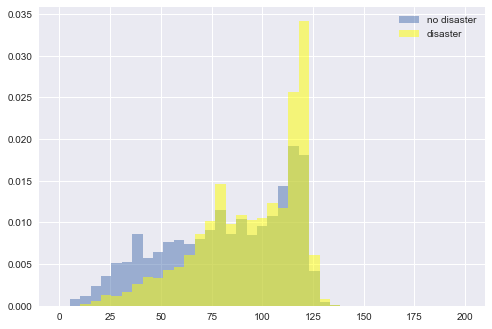

In [44]:
#text length might be important feature
bins=np.linspace(0,200,40) 

pyplot.hist(df[df['target']==0]['text_len'], bins, alpha=0.5, density=True, label='no disaster')
pyplot.hist(df[df['target']==1]['text_len'], bins, alpha=0.5, density=True, label='disaster',color='yellow')
pyplot.legend(loc='upper right')

<AxesSubplot:ylabel='text_special_string'>

Text(0.5, 1.0, 'Not disaster tweets special strings')

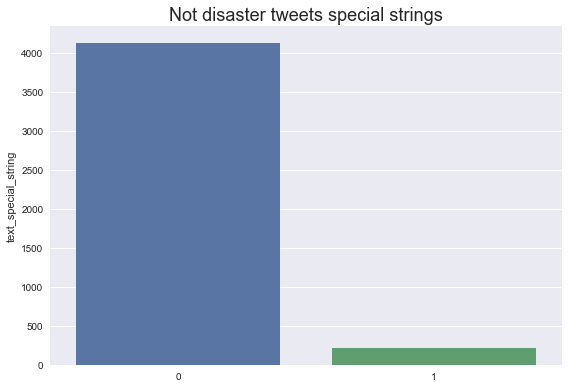

In [60]:
pyplot.style.use('seaborn')
sns.barplot(df[df['target']==0]['text_special_string'].value_counts().index,df[df['target']==0]['text_special_string'].value_counts())
pyplot.title('Not disaster tweets special strings',size=18)
pyplot.tight_layout() 

<AxesSubplot:ylabel='text_special_string'>

Text(0.5, 1.0, 'Disaster tweets special strings')

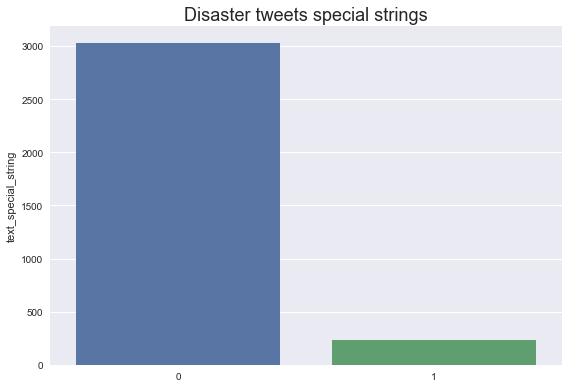

In [61]:
sns.barplot(df[df['target']==1]['text_special_string'].value_counts().index,df[df['target']==1]['text_special_string'].value_counts())
pyplot.title('Disaster tweets special strings',size=18)
pyplot.tight_layout() 

(array([6.47455090e-02, 7.21556886e-02, 5.02994012e-02, 3.80239521e-02,
        2.86676647e-02, 2.52245509e-02, 1.48203593e-02, 7.85928144e-03,
        4.34131737e-03, 2.76946108e-03, 1.42215569e-03, 1.42215569e-03,
        4.49101796e-04, 1.27245509e-03, 8.98203593e-04, 9.73053892e-04,
        9.73053892e-04, 5.98802395e-04, 1.12275449e-03, 6.73652695e-04,
        2.99401198e-04, 3.74251497e-04, 1.12275449e-03, 4.49101796e-04,
        3.74251497e-04, 2.24550898e-04, 2.24550898e-04, 3.74251497e-04,
        2.24550898e-04, 7.48502994e-05, 2.99401198e-04, 8.23353293e-04,
        1.42215569e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]),
 array([  0.        ,   3.07692308,   6.15384615,   9.23076923,
         12.30769231,  15.38461538,  18.46153846,  21.53846154,
         24.61538462,  27.69230769,  30.76923077,  33.84615385,
         36.92307692,  40.        ,  43.07692308,  46.15384615,
         49.23076923,  52.30769231,  5

(array([3.12977683e-02, 5.64353409e-02, 6.51788444e-02, 5.98135127e-02,
        4.18297157e-02, 2.88138184e-02, 1.67915011e-02, 8.14735555e-03,
        4.47110975e-03, 1.78844390e-03, 8.94221950e-04, 1.58972791e-03,
        7.94863956e-04, 6.95505961e-04, 2.98073983e-04, 4.96789972e-04,
        4.96789972e-04, 5.96147967e-04, 2.98073983e-04, 6.95505961e-04,
        4.96789972e-04, 4.96789972e-04, 1.98715989e-04, 3.97431978e-04,
        5.96147967e-04, 9.93579945e-05, 2.98073983e-04, 9.93579945e-05,
        0.00000000e+00, 9.93579945e-05, 9.93579945e-05, 1.98715989e-04,
        4.96789972e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]),
 array([  0.        ,   3.07692308,   6.15384615,   9.23076923,
         12.30769231,  15.38461538,  18.46153846,  21.53846154,
         24.61538462,  27.69230769,  30.76923077,  33.84615385,
         36.92307692,  40.        ,  43.07692308,  46.15384615,
         49.23076923,  52.30769231,  5

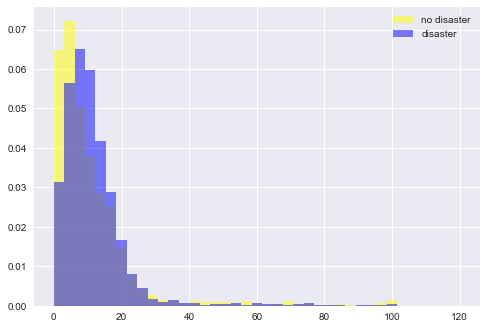

In [47]:
bins=np.linspace(0,120,40) 

pyplot.hist(df[df['target']==0]['text_capitalized'], bins, alpha=0.5, density=True, color='yellow',label='no disaster')
pyplot.hist(df[df['target']==1]['text_capitalized'], bins, alpha=0.5, density=True,color='blue',label='disaster')
pyplot.legend(loc='upper right')

(array([5.56116102e-01, 1.03766413e-01, 9.16378715e-02, 7.97339323e-02,
        5.00863856e-02, 2.78507256e-02, 2.13372495e-02, 1.30269523e-02,
        9.43331030e-03, 6.28887353e-03, 2.47062889e-03, 3.81824464e-03,
        3.81824464e-03, 2.47062889e-03, 4.49205252e-04, 6.73807878e-04,
        6.73807878e-04, 2.24602626e-04, 0.00000000e+00, 0.00000000e+00,
        2.24602626e-04, 2.24602626e-04, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 2.24602626e-04, 0.00000000e+00, 0.00000000e+00,
        2.24602626e-04, 0.00000000e+00, 2.24602626e-04, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]),
 array([ 0.        ,  1.02564103,  2.05128205,  3.07692308,  4.1025641 ,
         5.12820513,  6.15384615,  7.17948718,  8.20512821,  9.23076923,
        10.25641026, 11.28205128, 12.30769231, 13.33333333, 14.35897436,
        15.38461538, 16.41025641, 17.43589744, 18.46153846, 19.48717949,
  

(array([3.48448487e-01, 1.56190767e-01, 1.44565882e-01, 1.05518190e-01,
        6.91531642e-02, 4.35188016e-02, 3.01054723e-02, 1.96728829e-02,
        1.60959951e-02, 9.24029349e-03, 8.34607154e-03, 5.96147967e-03,
        3.27881382e-03, 2.68266585e-03, 1.49036992e-03, 2.98073983e-03,
        1.19229593e-03, 8.94221950e-04, 2.98073983e-04, 2.98073983e-04,
        2.98073983e-04, 0.00000000e+00, 2.98073983e-04, 2.98073983e-04,
        5.96147967e-04, 0.00000000e+00, 2.98073983e-04, 0.00000000e+00,
        8.94221950e-04, 5.96147967e-04, 1.19229593e-03, 2.98073983e-04,
        0.00000000e+00, 2.98073983e-04, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]),
 array([ 0.        ,  1.02564103,  2.05128205,  3.07692308,  4.1025641 ,
         5.12820513,  6.15384615,  7.17948718,  8.20512821,  9.23076923,
        10.25641026, 11.28205128, 12.30769231, 13.33333333, 14.35897436,
        15.38461538, 16.41025641, 17.43589744, 18.46153846, 19.48717949,
  

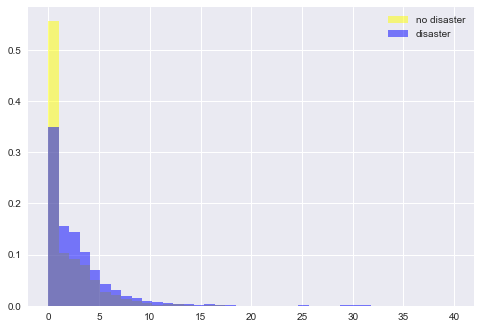

In [48]:
bins=np.linspace(0,40,40)

pyplot.hist(df[df['target']==0]['text_digit'], bins, alpha=0.5, density=True, color='yellow',label='no disaster')
pyplot.hist(df[df['target']==1]['text_digit'], bins, alpha=0.5, density=True,color='blue',label='disaster')
pyplot.legend(loc='upper right')

(array([6.81736527e-02, 7.35179641e-02, 4.21257485e-02, 6.55688623e-03,
        3.09880240e-03, 6.73652695e-04, 3.14371257e-04, 2.69461078e-04,
        2.24550898e-04, 0.00000000e+00, 4.49101796e-05, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]),
 array([  0.        ,   5.12820513,  10.25641026,  15.38461538,
         20.51282051,  25.64102564,  30.76923077,  35.8974359 ,
         41.02564103,  46.15384615,  51.28205128,  56.41025641,
         61.53846154,  66.66666667,  71.79487179,  76.92307692,
         82.05128205,  87.17948718,  9

(array([0.04202843, 0.10688933, 0.03797463, 0.0064384 , 0.00131153,
        0.00023846, 0.00011923, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ]),
 array([  0.        ,   5.12820513,  10.25641026,  15.38461538,
         20.51282051,  25.64102564,  30.76923077,  35.8974359 ,
         41.02564103,  46.15384615,  51.28205128,  56.41025641,
         61.53846154,  66.66666667,  71.79487179,  76.92307692,
         82.05128205,  87.17948718,  92.30769231,  97.43589744,
        102.56410256, 107.69230769, 112.82051282, 117.94871795,
        123.07692308, 128.20512821, 133.33333333, 138.46153846,
        143.589743

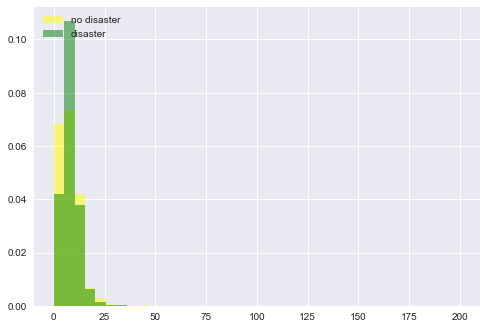

In [49]:
bins=np.linspace(0,200,40) #this will return an array of 40 evenly spaced numbers between 0 and 200

pyplot.hist(df[df['target']==0]['text_punctuation'], bins, alpha=0.5, density=True, color='yellow',label='no disaster')
pyplot.hist(df[df['target']==1]['text_punctuation'], bins, alpha=0.5, density=True,color='green',label='disaster')
pyplot.legend(loc='upper left')

<Figure size 1008x720 with 0 Axes>

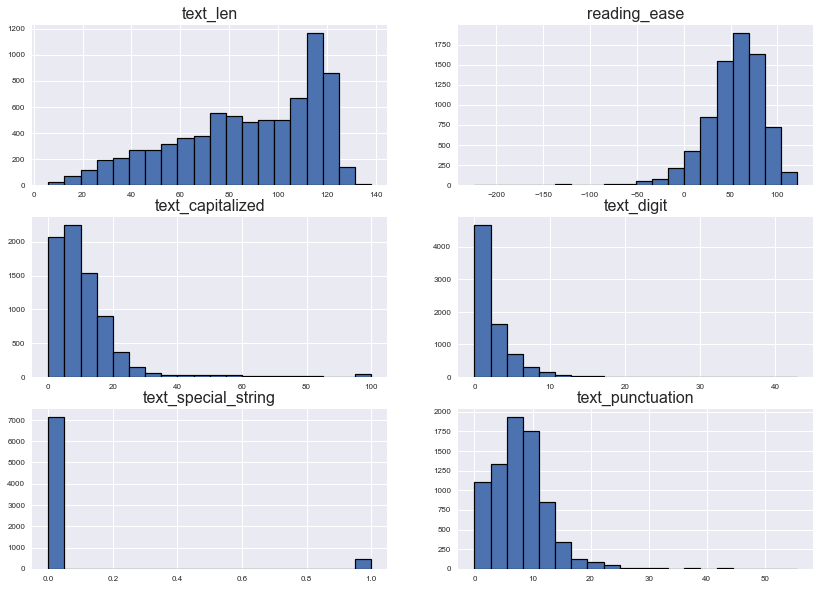

In [50]:
#Checking the shape of numeric features

def plot_hist(ax, feature, title):
    ax.hist(feature, bins=20, edgecolor='black', linewidth=1.2);
    ax.set_title(title, fontsize=16);
    ax.tick_params(axis='both', which='major', labelsize=8);
    ax.grid(True);

pyplot.figure(figsize=(14, 10));
pyplot.grid(True);
plot_hist(pyplot.subplot(3, 2, 1), df['text_len'], 'text_len')
plot_hist(pyplot.subplot(3, 2, 2), df['flesch_reading_ease'], 'reading_ease')
plot_hist(pyplot.subplot(3, 2, 3), df['text_capitalized'], 'text_capitalized')
plot_hist(pyplot.subplot(3, 2, 4), df['text_digit'], 'text_digit')
plot_hist(pyplot.subplot(3, 2, 5), df['text_special_string'], 'text_special_string')
plot_hist(pyplot.subplot(3, 2, 6), df['text_punctuation'], 'text_punctuation')